In [ ]:
# ✅ Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# main_pcb_classifier.py

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# -----------------------------
# ▶ Custom Dataset Class
# -----------------------------
class PCBDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = self.df["filename"].values
        self.labels = (self.df[["open", "short", "pin-hole"]] > 0).astype("float32").values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx])
        return image, label

# -----------------------------
# ▶ Simple CNN Model (Pre-trained X)
# -----------------------------
class PCBClassifier(nn.Module):
    def __init__(self):
        super(PCBClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# ▶ Accuracy 계산 함수
# -----------------------------
def multi_label_accuracy(y_true, y_pred, threshold=0.7):
    y_pred = (y_pred > threshold).float()
    correct = (y_pred == y_true).float().sum()
    return correct / y_true.numel()

# -----------------------------
# ▶ Training Function
# -----------------------------
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=50):
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_acc = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            acc = multi_label_accuracy(labels, outputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)

        model.eval()
        total_val_loss, total_val_acc = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, labels)
                acc = multi_label_accuracy(labels, outputs)
                total_val_loss += loss.item()
                total_val_acc += acc.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # 테스트 정확도 평가
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).int().cpu().numpy()
            test_preds.extend(preds)
            test_labels.extend(labels.numpy())

    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)
    test_acc = (test_preds == test_labels).mean()
    print(f"\n테스트 정확도: {test_acc:.4f}")

    # ▶ 성능 지표 시각화
    class_names = ["open", "short", "pin-hole"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i in range(3):
        cm = multilabel_confusion_matrix(test_labels[:, i], test_preds[:, i])[1]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"Confusion Matrix: {class_names[i]}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
    plt.tight_layout()
    plt.show()

    print("\n▶ 정밀도 (Precision):", precision_score(test_labels, test_preds, average=None))
    print("▶ 재현율 (Recall):", recall_score(test_labels, test_preds, average=None))
    print("▶ F1-score:", f1_score(test_labels, test_preds, average=None))

    plt.figure(figsize=(8, 4))
    f1 = f1_score(test_labels, test_preds, average=None)
    sns.barplot(x=class_names, y=f1)
    plt.title("F1-Score per Class")
    plt.ylim(0, 1)
    plt.show()

    return model, test_preds




[Epoch 1] Train Loss: 0.6749, Train Acc: 0.5917, Val Loss: 0.6807, Val Acc: 0.5733
[Epoch 2] Train Loss: 0.6703, Train Acc: 0.5917, Val Loss: 0.6800, Val Acc: 0.5733
[Epoch 3] Train Loss: 0.6707, Train Acc: 0.5917, Val Loss: 0.6791, Val Acc: 0.5733
[Epoch 4] Train Loss: 0.6686, Train Acc: 0.5917, Val Loss: 0.6672, Val Acc: 0.5733
[Epoch 5] Train Loss: 0.6543, Train Acc: 0.5908, Val Loss: 0.6126, Val Acc: 0.5825
[Epoch 6] Train Loss: 0.4594, Train Acc: 0.7100, Val Loss: 0.2945, Val Acc: 0.7950
[Epoch 7] Train Loss: 0.3251, Train Acc: 0.8292, Val Loss: 0.3234, Val Acc: 0.9267
[Epoch 8] Train Loss: 0.3044, Train Acc: 0.8406, Val Loss: 0.2501, Val Acc: 0.8358
[Epoch 9] Train Loss: 0.2813, Train Acc: 0.8529, Val Loss: 0.2477, Val Acc: 0.8092
[Epoch 10] Train Loss: 0.2704, Train Acc: 0.8567, Val Loss: 0.2236, Val Acc: 0.8550
[Epoch 11] Train Loss: 0.2602, Train Acc: 0.8642, Val Loss: 0.2162, Val Acc: 0.9025
[Epoch 12] Train Loss: 0.2793, Train Acc: 0.8640, Val Loss: 0.2167, Val Acc: 0.9092
[

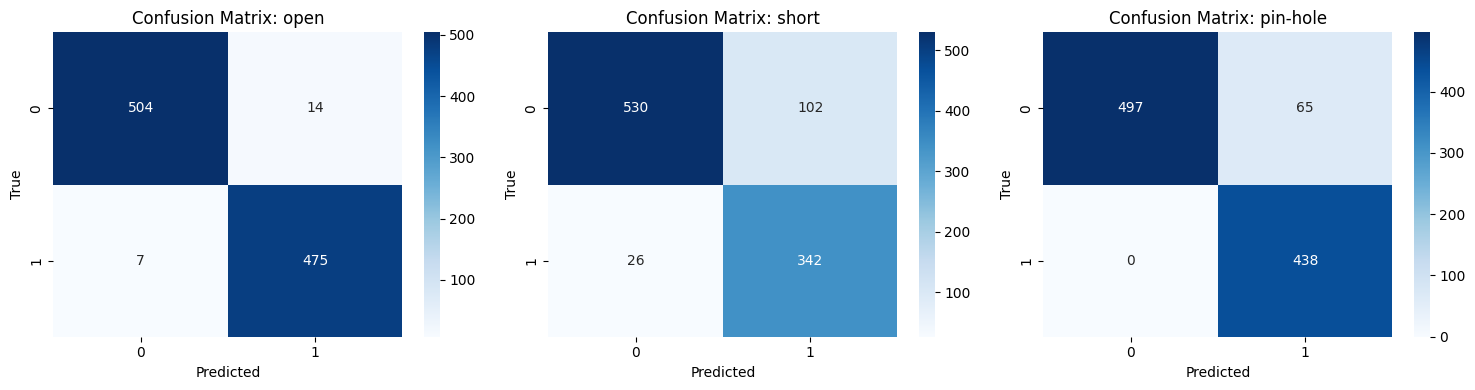


▶ 정밀도 (Precision): [0.97137014 0.77027027 0.87077535]
▶ 재현율 (Recall): [0.98547718 0.92934783 1.        ]
▶ F1-score: [0.97837281 0.84236453 0.93092455]


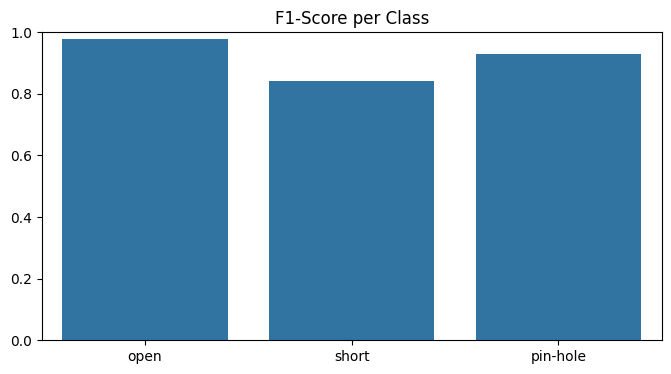


결과가 'test_output.csv'에 저장되었습니다!


In [ ]:
# -----------------------------
# ▶ Main
# -----------------------------
if __name__ == "__main__":
    trainval_csv   = "/content/drive/MyDrive/Colab Notebooks/DL/trainval_label.csv"
    test_csv       = "/content/drive/MyDrive/Colab Notebooks/DL/test_label.csv"
    train_img_dir  = "/content/drive/MyDrive/Colab Notebooks/DL/train"
    test_img_dir   = "/content/drive/MyDrive/Colab Notebooks/DL/test"


    df = pd.read_csv(trainval_csv)
    df_test = pd.read_csv(test_csv)

    stratify_col = (df[["open", "short", "pin-hole"]] > 0).any(axis=1)
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=stratify_col)

    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor()
    ])

    train_dataset = PCBDataset(df_train, train_img_dir, transform)
    val_dataset   = PCBDataset(df_val, train_img_dir, transform)
    test_dataset  = PCBDataset(df_test, test_img_dir, transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PCBClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model, test_preds = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=50)

    output = []
    for pred in test_preds:
        has_defect = int(np.any(pred == 1))
        open_, short_, pinhole = map(int, pred)
        output.append([has_defect, open_, short_, 0, 0, 0, pinhole])

    df_test_out = df_test.copy()
    df_test_out[["defect", "open", "short", "mousebite", "spur", "copper", "pin-hole"]] = output
    df_test_out.to_csv("test_output.csv", index=False)
    print("\n결과가 'test_output.csv'에 저장되었습니다!")